In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/week3_CAM/modelsave/'

# using imagenette as IMAGEWOOFPATH
IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagenette2'

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("torch version:", torch.__version__)
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import cv2

torch version: 1.7.0+cu101
check device: Tesla T4
how many?: 1
so can i use it? True


In [ ]:
# transformation for CIFAR 10
# yet to implement standard color augmentation

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224, padding=28),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),         
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [ ]:
train_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')

train_loader 296
test_loader 3926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


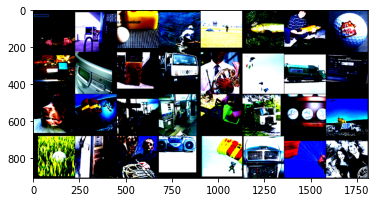

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# define the basic building blocks for ResNet

# option A
class Padding(nn.Module):
    def __init__(self, in_c, out_c):
        super(Padding, self).__init__()
        self.padding = F.pad
        self.pad_dim = (out_c - in_c) / 2

    def forward(self, x):
        x = self.padding(x, (0,0,0,0, self.pad_dim, self.pad_dim), "constant", 0)
        return x

# option Mine
class Concat(nn.Module):
    def __init__(self, in_c, out_c):
        super(Concat, self).__init__()
        
        self.dim_remainder = (out_c - in_c) % in_c
        self.concat_times = (out_c - in_c) // in_c


    def forward(self, x):

        cat_x = [x] * self.concat_times
        cat_x = torch.cat(cat_x, dim=0)
        cat_x = torch.cat((cat_x, x[:self.dim_remainder]), dim=0)

        return cat_x

class BuildingBlock(nn.Module):

    def __init__(self, in_c, out_c, stride=1, option='B'):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.shortcut = nn.Sequential()
        if in_c != out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, out_c)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class Bottleneck(nn.Module):

    def __init__(self, in_c, process_c, stride=1, option='B'):
        super(Bottleneck, self).__init__()

        self.out_c = process_c * 4

        self.conv1 = nn.Conv2d(in_c, process_c, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(process_c)

        self.conv2 = nn.Conv2d(process_c, process_c, kernel_size=3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(process_c)

        self.conv3 = nn.Conv2d(process_c, self.out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(self.out_c)

        self.shortcut = nn.Sequential()
        if in_c != self.out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, self.out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, self.out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(self.out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, self.out_c)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        # slightly changed for CIFAR10
        # in order to have dimension 32x32 --> 16x16
        self.conv_gate = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_gate = nn.BatchNorm2d(64)
        self.maxpool_gate = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn_gate(self.conv_gate(x)))
        x = self.maxpool_gate(x)
        return x

In [ ]:
class ResNet18B(nn.Module):
    def __init__(self):
        super(ResNet18B, self).__init__()

        self.gate = Gate()

        self.conv2_1 = BuildingBlock(64, 64, 1, 'B')
        self.conv2_2 = BuildingBlock(64, 64, 1, 'B')

        self.conv3_1 = BuildingBlock(64, 128, 2, 'B')
        self.conv3_2 = BuildingBlock(128, 128, 1, 'B')

        self.conv4_1 = BuildingBlock(128, 256, 2, 'B')
        self.conv4_2 = BuildingBlock(256, 256, 1, 'B')

        self.conv5_1 = BuildingBlock(256, 512, 1, 'B')
        self.conv5_2 = BuildingBlock(512, 512, 1, 'B')

        self.output = nn.Linear(512, 10)

    def forward(self, x):
        #print("input", x.shape)
        x = self.gate(x)

        #print("1", x.shape)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print("2", x.shape)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        #print("3", x.shape)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        #print("4", x.shape)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        #print("5", x.shape)

        x = F.avg_pool2d(x, 14)
        #print("avgpool", x.shape)

        x = x.view(-1, 512)
        #print("fc", x.shape)

        x = self.output(x)

        return x

In [ ]:
resnet = ResNet18B()
resnet.to(device)

ResNet18B(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv2_2): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNor

In [ ]:
resnet.load_state_dict(torch.load(MODELPATH+f'woof_RestNet18B', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
resnet_front = nn.Sequential(
    resnet.gate,
    resnet.conv2_1,
    resnet.conv2_2,
    resnet.conv3_1,
    resnet.conv3_2,
    resnet.conv4_1,
    resnet.conv4_2,
    resnet.conv5_1,
    resnet.conv5_2
)

In [ ]:
params = list(ResNet18B().parameters())
weight = np.squeeze(params[-2].data.numpy())

In [ ]:
def return_CAM(feature_map, weight, idx):
    size_upsample = (224,224)

    bz, nc, h, w = feature_map.shape
    #print(bz, nc, h, w)

    image_matrix_2d = feature_map.reshape((nc, h*w))
    # preparing for matrix mul
    #https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923
    
    cam = np.matmul(weight[idx], image_matrix_2d)
    # matrix mul
    # 1 512 512 196 = 1 196
    print(cam.shape)
    cam = cam.reshape(h,w)

    print(cam.shape)

    # normalization
    cam = cam - cam.min()
    cam = cam / cam.max()
    

    cam = np.uint8(255*cam) # necessary step for upsampling
    upsampled_cam = cv2.resize(cam, size_upsample)

    return upsampled_cam, cam

In [ ]:
resnet.eval()

dataiter = iter(test_loader)
image, label = dataiter.next()
image = image.to(device)

pred = resnet(image)

feature_map = resnet_front(image)

pred_label = pred.argmax(axis=1).detach().cpu().numpy()

cam_upsample, cam_downsample = return_CAM(feature_map.detach().cpu(), weight, pred_label)

image_show = np.transpose(np.squeeze(image.detach().cpu().numpy()), (1,2,0))

torch.Size([1, 196])
torch.Size([14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


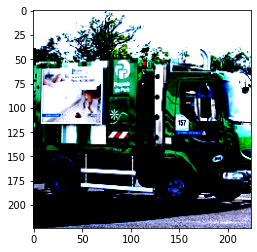

In [ ]:
plt.imshow(image_show)

In [ ]:
plt.imshow(cam_upsample)

In [ ]:
plt.imshow(cam_downsample)

In [ ]:
heatmap = cv2.applyColorMap(cam_upsample, cv2.COLORMAP_RAINBOW)

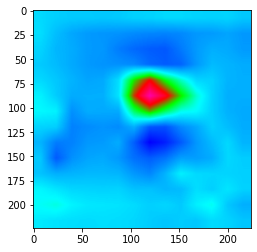

In [ ]:
plt.imshow(heatmap)

In [ ]:
result = heatmap * 0.1 + ((image_show-image_show.min())/image_show.max()) * 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


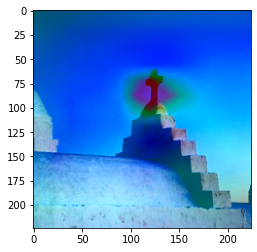

In [ ]:
plt.imshow(image_show)
plt.imshow(heatmap, alpha=0.4)
# https://www.programmersought.com/article/37434177682/

In [ ]:
image_show

array([[[-0.22140822, -0.06537759,  0.22447886],
        [-0.30957296, -0.17415896,  0.13457587],
        [-0.4506366 , -0.33733103, -0.02724952],
        ...,
        [-1.6673102 , -1.8240099 , -1.7354065 ],
        [-2.0023365 , -2.0959632 , -1.8073288 ],
        [-1.6496773 , -1.7696192 , -1.627523  ]],

       [[-0.9267263 , -0.7543263 , -0.56666744],
        [-0.9090933 , -0.7180658 , -0.5307063 ],
        [-0.6445991 , -0.48237285, -0.2789779 ],
        ...,
        [-1.5086137 , -1.5701867 , -1.4656975 ],
        [-1.826007  , -1.8602704 , -1.6994452 ],
        [-1.5967785 , -1.6064472 , -1.4656975 ]],

       [[-1.7202092 , -1.6064472 , -1.4656975 ],
        [-1.826007  , -1.6970983 , -1.53762   ],
        [-1.7554752 , -1.6427076 , -1.4656975 ],
        ...,
        [-1.9318047 , -1.914661  , -1.6994452 ],
        [-2.0905013 , -2.0597029 , -1.7893482 ],
        [-2.0199695 , -1.9690517 , -1.7354065 ]],

       ...,

       [[ 1.7182167 ,  2.0921197 ,  2.4900346 ],
        [ 1

In [ ]:
heatmap

array([[[232,   0,   0],
        [232,   0,   0],
        [232,   0,   0],
        ...,
        [208,   0,   0],
        [208,   0,   0],
        [208,   0,   0]],

       [[232,   0,   0],
        [232,   0,   0],
        [232,   0,   0],
        ...,
        [208,   0,   0],
        [208,   0,   0],
        [208,   0,   0]],

       [[232,   0,   0],
        [232,   0,   0],
        [232,   0,   0],
        ...,
        [208,   0,   0],
        [208,   0,   0],
        [208,   0,   0]],

       ...,

       [[255, 208,   0],
        [255, 208,   0],
        [255, 208,   0],
        ...,
        [255, 216,   0],
        [255, 216,   0],
        [255, 216,   0]],

       [[255, 208,   0],
        [255, 208,   0],
        [255, 208,   0],
        ...,
        [255, 216,   0],
        [255, 216,   0],
        [255, 216,   0]],

       [[255, 208,   0],
        [255, 208,   0],
        [255, 208,   0],
        ...,
        [255, 216,   0],
        [255, 216,   0],
        [255, 216,   0]]